In [1]:
### README ###

# This script analyses datasets in table 1.
# The following 2 cells import libraries and define nice colour codes,
# the next cell defines a general function that estimates the error from data fitting,
# and the next cell defines two fit functions.
# Cells further down take the datasets and analyse them independently.

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

In [3]:
# nice colours! Feel free to use them :) - Daoyuan Qian 2024
colorsBlue = ['#b3e5fc', '#0091ea']
colorsRed = ['#f18e86', '#e83b47']
colorsYellow = ['#fed9ae', '#fbad54']
colorsPurple = ['#d69bc5' ,'#a8509f']
colorsGreyOrange = ['#c3c3c3', '#f8a834']
colors = np.array([colorsBlue, colorsRed, colorsYellow, colorsPurple, colorsGreyOrange])

In [4]:
# generate 500 mock datasets for a given parameter fit, then estimate the spread in fitting parameters
def get_error(x, y, popt, function):
    new_y = function(x, *popt)
    new_y_matrix = np.array([np.random.normal((y+new_y[i])/2, abs(y-new_y[i]), 500) for i, y in enumerate(y)]).T
    parameters = []
    p0 = np.copy(popt)
    for j, row in enumerate(new_y_matrix):
        popt, pcov = curve_fit(function, x, row, p0=p0)
        parameters.append(popt)
    para = np.array(parameters)
    para_result = np.nanpercentile(para, [16, 84], axis=0)
    errors = (para_result.T[:, 1] - para_result.T[:, 0]) / 2
    return errors

In [5]:
# homotypic response with diagonal below x0, and slope R11 above x0
def fit_fn_lin_inc(x, x0, R11):
    x = np.array(x)
    _ = (x > x0).astype(int)
    return (1 - _) * x + (x0 + R11 * (x - x0)) * _

# heterotypic response with 1 below x0, and exponential decrease above x0
def fit_fn_exp_dec(x, x0, a):
    mask = np.array(x > x0).astype(int)
    return np.exp( - (x - x0) * mask * a)

<IPython.core.display.Javascript object>


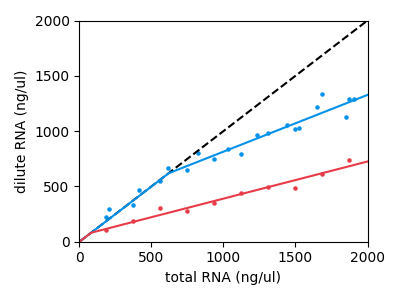

analysing table_data_1
c_sat value calculated is 618.41 +- 48.49
D value calculated is 0.49 +- 0.03

analysing table_data_2
c_sat value calculated is 81.27 +- 31.72
D value calculated is 0.66 +- 0.02



In [6]:
# table entries (1) and (2)
names = ['table_data_1',
         'table_data_2']

dfs = []
for i in range(len(names)):
    dfs.append(pd.read_csv('{}.csv'.format(names[i])))
    
plt.figure(figsize = (4, 3))
xx = np.linspace(0, 2000, 1000)
plt.plot(xx, xx, linestyle = 'dashed', color = 'black')
for i in range(len(names)):
    _x = dfs[i]['Ctot']
    _y = dfs[i]['Cdil']
    plt.scatter(_x, _y, color = colors[i][1], s = 5)
    popt, pcov = curve_fit(fit_fn_lin_inc, _x, _y, p0 = (700, 1), maxfev=2000,
                           bounds = ((0,0), (1000, 100)))
    plt.plot(xx, fit_fn_lin_inc(xx, *popt), color = colors[i][1])
    error = get_error(_x, _y, popt, fit_fn_lin_inc)
    print('analysing {0}'.format(names[i]))
    print('c_sat value calculated is {0:.2f} +- {1:.2f}'.format(popt[0], error[0]))
    print('D value calculated is {0:.2f} +- {1:.2f}\n'.format(1 - popt[1], error[1]))
    
plt.xlim(0, 2000)
plt.ylim(0, 2000)
plt.xlabel('total RNA (ng/ul)')
plt.ylabel('dilute RNA (ng/ul)')
plt.tight_layout()

<IPython.core.display.Javascript object>


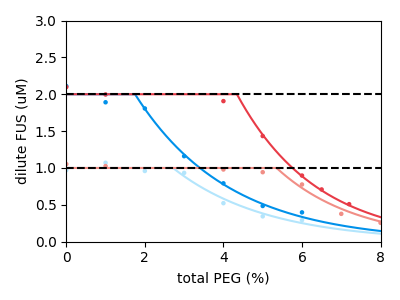

analysing table_data_3
delta_csat value calculated is 0.97 +- 0.13
R12 value calculated is 0.63 +- 0.02
D value calculated is 0.61 +- 0.10

analysing table_data_4
delta_csat value calculated is 1.01 +- 0.16
R12 value calculated is 0.74 +- 0.02
D value calculated is 0.74 +- 0.14



In [7]:
# table entry (3) & (4)

### fitting detail ###

# The data come in pairs: without hexanediol (3) and with hexanediol (4).
# For each pair, the heterotypic response is 0 without phase separation (FUS does not respond to addition of PEG)
# and beyond some threshold PEG we assume dilute FUS decays exponentially.
# This is just a phenomenological fit that seems to work, other functional forms can be used.
# the double_fit takes the pairs of data, clamps the exponential factor for the two responses, and does the fitting
# this leads to a heterotypic response R12, which we take as the average gradient of the fitting function at threshold
# the different thresholds fitted, delta_csat, is used to compute the phase boundary gradient (dFUS / dPEG)
# where dFUS = 2uM - 1uM = 1, and dPEG = delta_csat
# FUS dominance is R12 / (dFUS/dPEG), see the PNAS paper https://www.pnas.org/doi/abs/10.1073/pnas.2407453121

names = ['table_data_3',
         'table_data_4']

dfs = []
for i in range(len(names)):
    dfs.append(pd.read_csv('{}.csv'.format(names[i])))

plt.figure(figsize = (4, 3))
xx = np.linspace(0, 8, 1000)
for i in range(len(names)):
    
    _l = dfs[i]['C1tot'].values
    _x = dfs[i]['C2tot'].values
    _y = dfs[i]['C1dil'].values
    
    plt.scatter(_x, _y, color = colors[i][(_l-1).astype(int)], s = 5)
    
    # use a double gaussian fit to get R12 response
    def double_fit(x, xA0, xB0, a):
        return np.append(1 * fit_fn_exp_dec(x[0:7], xA0, a), 2 * fit_fn_exp_dec(x[7:], xB0, a))

    popt, pcov = curve_fit(double_fit, _x, _y, p0 = (3, 3, 1), maxfev=2000,
                       bounds = ((0,0,0), (100, 100,100)))
    error = get_error(_x, _y, popt, double_fit)
    
    aa = popt[2]
    R12 = 1.5 * aa # the average R12 over two lines
    error_R12 = 1.5 * error[2]
    delta_csat = popt[0] - popt[1]
    error_csat = error[0] + error[1]
    D = - R12 / ( - 1 / (delta_csat))
    error_D  = D * ((error_csat / delta_csat) + (error_R12 / R12))
    
    print('analysing {0}'.format(names[i]))
    print('delta_csat value calculated is {0:.2f} +- {1:.2f}'.format(delta_csat, error_csat))
    print('R12 value calculated is {0:.2f} +- {1:.2f}'.format(R12, error_R12))
    print('D value calculated is {0:.2f} +- {1:.2f}\n'.format(D, error_D))
    
    for j in range(2):
        plt.plot(xx, (1 + j) * fit_fn_exp_dec(xx, *popt[[j,-1]]), color = colors[i][j])
    
    
plt.axhline(1, linestyle = 'dashed', color = 'black')
plt.axhline(2, linestyle = 'dashed', color = 'black')

plt.xlim(0, 8)
plt.ylim(0, 3)
plt.xlabel('total PEG (%)')
plt.ylabel('dilute FUS (uM)')
plt.tight_layout()

<IPython.core.display.Javascript object>


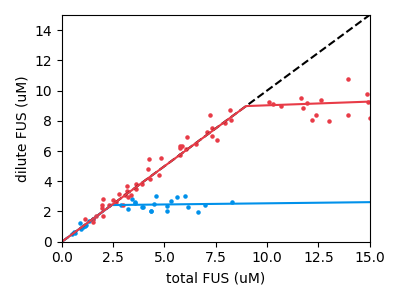

analysing table_data_5
c_sat value calculated is 2.43 +- 0.11
D value calculated is 0.98 +- 0.04

analysing table_data_6
c_sat value calculated is 8.97 +- 0.24
D value calculated is 0.95 +- 0.03



In [8]:
# table entries (5) and (6)
names = ['table_data_5',
         'table_data_6']

dfs = []
for i in range(len(names)):
    dfs.append(pd.read_csv('{}.csv'.format(names[i])))
    
plt.figure(figsize = (4, 3))
xx = np.linspace(0, 15, 1000)
plt.plot(xx, xx, linestyle = 'dashed', color = 'black')
for i in range(len(names)):
    _x = dfs[i]['Ctot']
    _y = dfs[i]['Cdil']
    plt.scatter(_x, _y, color = colors[i][1], s = 5)
    popt, pcov = curve_fit(fit_fn_lin_inc, _x, _y, p0 = (1, 1), maxfev=2000,
                           bounds = ((0,0), (100, 100)))
    plt.plot(xx, fit_fn_lin_inc(xx, *popt), color = colors[i][1])
    
    error = get_error(_x, _y, popt, fit_fn_lin_inc)
    print('analysing {0}'.format(names[i]))
    print('c_sat value calculated is {0:.2f} +- {1:.2f}'.format(popt[0], error[0]))
    print('D value calculated is {0:.2f} +- {1:.2f}\n'.format(1 - popt[1], error[1]))
    
plt.xlim(0, 15)
plt.ylim(0, 15)
plt.xlabel('total FUS (uM)')
plt.ylabel('dilute FUS (uM)')
plt.tight_layout()

<IPython.core.display.Javascript object>


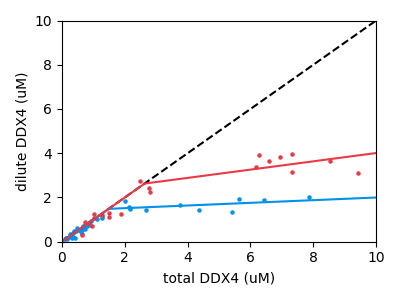

analysing table_data_7
c_sat value calculated is 1.49 +- 0.11
D value calculated is 0.94 +- 0.03

analysing table_data_8
c_sat value calculated is 2.63 +- 0.73
D value calculated is 0.81 +- 0.17



In [9]:
# table entries (7) and (8)
names = ['table_data_7',
         'table_data_8']

dfs = []
for i in range(len(names)):
    dfs.append(pd.read_csv('{}.csv'.format(names[i])))
    
plt.figure(figsize = (4, 3))
xx = np.linspace(0, 10, 1000)
plt.plot(xx, xx, linestyle = 'dashed', color = 'black')
for i in range(len(names)):
    _x = dfs[i]['Ctot']
    _y = dfs[i]['Cdil']
    plt.scatter(_x, _y, color = colors[i][1], s = 5)
    popt, pcov = curve_fit(fit_fn_lin_inc, _x, _y, p0 = (1, 1), maxfev=2000,
                           bounds = ((0,0), (100, 100)))
    plt.plot(xx, fit_fn_lin_inc(xx, *popt), color = colors[i][1])
    
    error = get_error(_x, _y, popt, fit_fn_lin_inc)
    print('analysing {0}'.format(names[i]))
    print('c_sat value calculated is {0:.2f} +- {1:.2f}'.format(popt[0], error[0]))
    print('D value calculated is {0:.2f} +- {1:.2f}\n'.format(1 - popt[1], error[1]))
    
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel('total DDX4 (uM)')
plt.ylabel('dilute DDX4 (uM)')
plt.tight_layout()

<IPython.core.display.Javascript object>


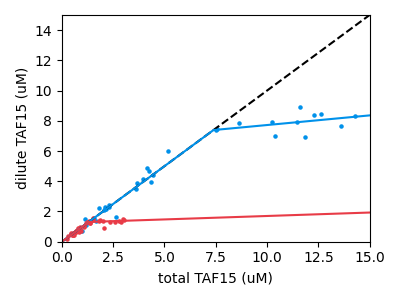

analysing table_data_9
c_sat value calculated is 7.39 +- 0.25
D value calculated is 0.87 +- 0.03

analysing table_data_10
c_sat value calculated is 1.31 +- 0.09
D value calculated is 0.95 +- 0.06



In [10]:
# table entries (9) and (10)
names = ['table_data_9',
         'table_data_10']

dfs = []
for i in range(len(names)):
    dfs.append(pd.read_csv('{}.csv'.format(names[i])))
    
plt.figure(figsize = (4, 3))
xx = np.linspace(0, 15, 1000)
plt.plot(xx, xx, linestyle = 'dashed', color = 'black')
for i in range(len(names)):
    _x = dfs[i]['Ctot']
    _y = dfs[i]['Cdil']
    plt.scatter(_x, _y, color = colors[i][1], s = 5)
    popt, pcov = curve_fit(fit_fn_lin_inc, _x, _y, p0 = (1, 1), maxfev=2000,
                           bounds = ((0,0), (100, 100)))
    plt.plot(xx, fit_fn_lin_inc(xx, *popt), color = colors[i][1])
    
    error = get_error(_x, _y, popt, fit_fn_lin_inc)
    print('analysing {0}'.format(names[i]))
    print('c_sat value calculated is {0:.2f} +- {1:.2f}'.format(popt[0], error[0]))
    print('D value calculated is {0:.2f} +- {1:.2f}\n'.format(1 - popt[1], error[1]))
    
plt.xlim(0, 15)
plt.ylim(0, 15)
plt.xlabel('total TAF15 (uM)')
plt.ylabel('dilute TAF15 (uM)')
plt.tight_layout()